In [1]:
import numpy as np
import matplotlib.pyplot as plt
from PIL import Image

Размер изображения: (1200, 782)
Форма numpy-массива: (782, 1200, 3)


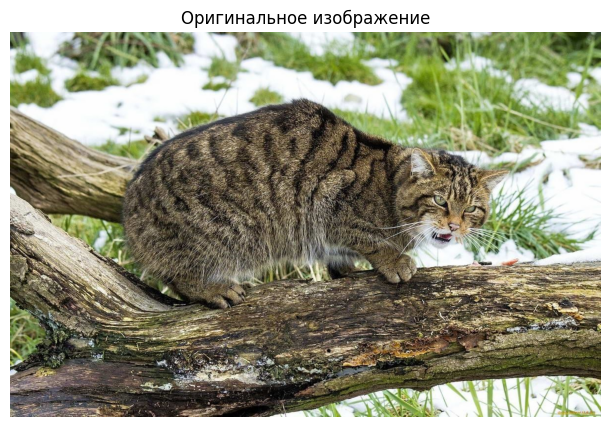

In [2]:
image = Image.open('cat.jpg')

image_array = np.array(image)

plt.figure(figsize=(10, 5))
plt.title("Оригинальное изображение")
plt.axis('off')
plt.imshow(image)

print("Размер изображения:", image.size)
print("Форма numpy-массива:", image_array.shape)

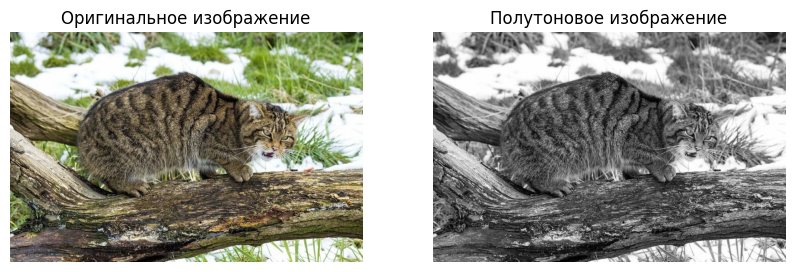

In [3]:
height, width, _ = image_array.shape
gray_image_array = np.zeros((height, width), dtype=np.uint8)

for i in range(height):
    for j in range(width):
        r, g, b = image_array[i, j].astype(np.int16)  # Преобразуем к int16, чтобы избежать переполнения
        gray_image_array[i, j] = (r + g + b) // 3

gray_image =  np.clip(gray_image_array, 0, 255).astype(np.uint8)

plt.figure(figsize=(10, 5))
plt.subplot(1, 2, 1)
plt.title("Оригинальное изображение")
plt.axis("off")
plt.imshow(image_array)

plt.subplot(1, 2, 2)
plt.title("Полутоновое изображение")
plt.axis("off")
plt.imshow(gray_image, cmap='gray')
plt.show()


u: 1, weight_background: 0.0006553708439897698, weight_foreground: 0.9993446291560102
mean_background: 0.0, mean_foreground: 124.91928746994247
variance_background: 0.0, variance_foreground: 4609465110.827912
sigma_w_squared: 4606444201.787888, S_min: inf
u: 2, weight_background: 0.0018265132139812447, weight_foreground: 0.9981734867860188
mean_background: 0.6411901983663943, mean_foreground: 125.0646801596266
variance_background: 215893.3036875263, variance_foreground: 4597946378.169433
sigma_w_squared: 4589548562.684502, S_min: 4606444201.787888
u: 3, weight_background: 0.003044543904518329, weight_foreground: 0.9969554560954816
mean_background: 1.1848092404620232, mean_foreground: 125.21503447730356
variance_background: 545375.8504096013, variance_foreground: 4586179204.596446
sigma_w_squared: 4572218041.074784, S_min: 4589548562.684502
u: 4, weight_background: 0.0044000426257459506, weight_foreground: 0.995599957374254
mean_background: 1.7440058125454105, mean_foreground: 125.38142

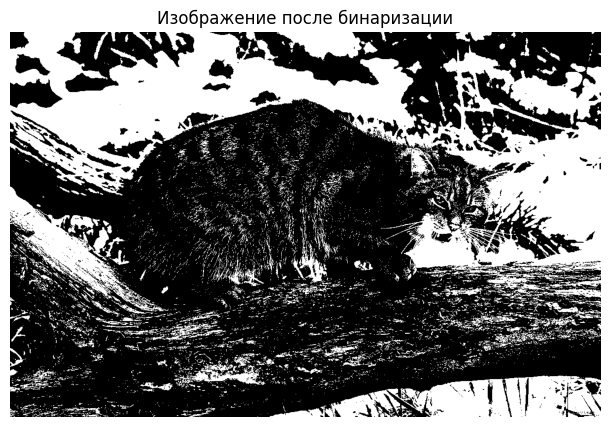

In [4]:
def otsu_threshold(image):
    # Вычисляем гистограмму
    histogram, _ = np.histogram(image, bins=256, range=(0, 255))
    
    # Максимальное значение интенсивности пикселя
    G_max = 255
    # Минимальное значение внутриклассовой дисперсии
    S_min = float('inf')
    # S_min = 255 
    # Оптимальный порог
    T = 0
    # Общее количество пикселей
    total_pixels = image.size
    # Шаг для перебора порогов
    t = 1
    
    # Нахождение оптимального порога по минимизации внутриклассовой дисперсии
    # Внутриклассовая дисперсия - это значение разброса интенсивностей пикселей внутри классов (фон <==> объект)
    # Меньшее значение дисперсии => лучше разделение на классы
    for u in range(1, G_max + 1, t):

        # Веса определяются как нормализованная сумма всех пикселей (доля пикселей в каждом классе)
        # Вес класса фона (нормализованный) от 0 до u - 1
        weight_background = np.sum(histogram[:u]) / total_pixels
        # Вес класса объекта (нормализованный) от u до G_max
        weight_foreground = np.sum(histogram[u:]) / total_pixels

        # Средние значения интенсивности пикселей для фона и объекта
        # Вычисляем и суммируем взвешенные значения интенсивности (Интенсивность пикселя * на количество пикселей с данной интенсивностью) для класса =>
        # => Общая интенсивность класса => Среднее значение интенсивности
        mean_background = np.sum(np.arange(u) * histogram[:u]) / np.sum(histogram[:u])
        mean_foreground = np.sum(np.arange(u, G_max + 1) * histogram[u:]) / np.sum(histogram[u:])
        
        # Дисперсии интенсивности для классов фона и объекта
        # Вычисляем дисперсию (среднее значение квадратов отклонений) => Скалярное произведение вектора квадратов отклонений на гистограмму => 
        # Взвешенная сумма квадратов отклонений / вес класса => Дисперсия интенсивности для класса
        variance_background = np.dot((np.arange(u) - mean_background) ** 2, histogram[:u]) / weight_background
        variance_foreground = np.dot((np.arange(u, G_max + 1) - mean_foreground) ** 2, histogram[u:]) / weight_foreground

        # Значение внутриклассовой дисперсии (взвешенная сумма дисперсий интенсивности для классов)
        sigma_w_squared = weight_background * variance_background + weight_foreground * variance_foreground
        

        print(f"u: {u}, weight_background: {weight_background}, weight_foreground: {weight_foreground}")
        print(f"mean_background: {mean_background}, mean_foreground: {mean_foreground}")
        print(f"variance_background: {variance_background}, variance_foreground: {variance_foreground}")
        print(f"sigma_w_squared: {sigma_w_squared}, S_min: {S_min}")
        
        # Используем внутриклассовую дисперсию как оценку качества разделения на классы
        if sigma_w_squared < S_min:
            S_min = sigma_w_squared
            T = u
    
    # Применяем порог T к изображению (создаем бинарную маску)
    binary_image = (image >= T).astype(np.uint8) * 255
    return binary_image


binary_image = otsu_threshold(gray_image)

plt.figure(figsize=(10, 5))
plt.title("Изображение после бинаризации")
plt.axis('off')
plt.imshow(binary_image, cmap='gray')
plt.show()

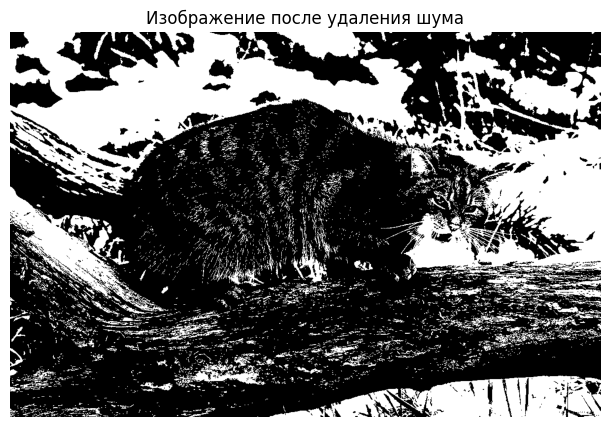

In [5]:
def remove_salt_and_pepper_noise(image):
    denoised_image = image.copy()
    
    height, width = image.shape
    
    for i in range(1, height - 1):
        for j in range(1, width - 1):
            pixel = image[i, j]
            neighbors = [
                image[i-1, j-1], image[i-1, j], image[i-1, j+1],
                image[i, j-1],                 image[i, j+1],
                image[i+1, j-1], image[i+1, j], image[i+1, j+1]
            ]
            
            if pixel == 255 and all(n == 0 for n in neighbors):
                denoised_image[i, j] = 0  
            elif pixel == 0 and all(n == 255 for n in neighbors):
                denoised_image[i, j] = 255  
    
    return denoised_image

denoised_image = remove_salt_and_pepper_noise(binary_image)

plt.figure(figsize=(10, 5))
plt.title("Изображение после удаления шума")
plt.axis('off')
plt.imshow(denoised_image, cmap='gray')
plt.show()

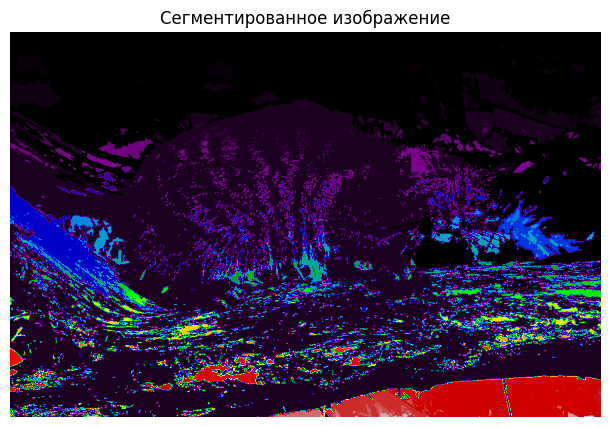

In [6]:
def seed_growth_segmentation(image):
    height, width = image.shape
    
    segments = np.zeros((height, width), dtype=np.int32)
    
    # Инициализация номера сегмента
    current_segment = 1
    
    def grow_segment(x, y, segment_number):
        stack = [(x, y)]
        
        while stack:
            cx, cy = stack.pop()
            
            # Учет границ
            if cx < 0 or cx >= height or cy < 0 or cy >= width:
                continue

            # Проверка на принадлежность к сегменту и критерию похожести
            if segments[cx, cy] != 0 or image[cx, cy] != image[x, y]:
                continue
            
            segments[cx, cy] = segment_number
            
            # Соседи
            stack.append((cx-1, cy))  
            stack.append((cx+1, cy))  
            stack.append((cx, cy-1))  
            stack.append((cx, cy+1))  
    
    for i in range(height):
        for j in range(width):
            if segments[i, j] == 0:
                grow_segment(i, j, current_segment)
                current_segment += 1
                
    return segments

segments = seed_growth_segmentation(denoised_image)

plt.figure(figsize=(10, 5))
plt.title("Сегментированное изображение")
plt.axis('off')
plt.imshow(segments, cmap='nipy_spectral')
plt.show()

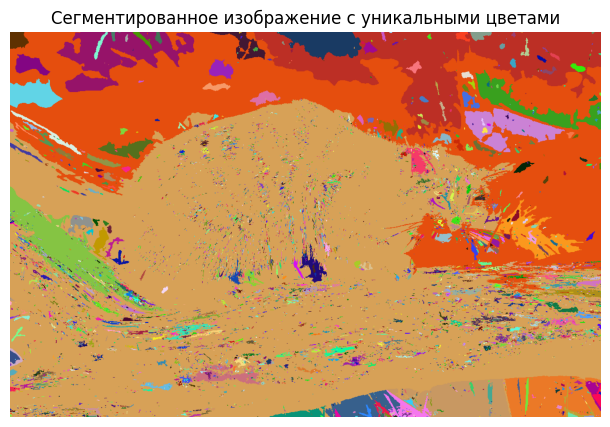

In [7]:
import random

def generate_random_color(used_colors):
    while True:
        color = (random.randint(0, 255), random.randint(0, 255), random.randint(0, 255))
        if color not in used_colors:
            used_colors.add(color)
            return color

def color_segments(segments):
    
    height, width = segments.shape
    
    colored_image = np.zeros((height, width, 3), dtype=np.uint8)
    
    used_colors = set()
    
    unique_segments = np.unique(segments)
    for segment in unique_segments:
        
        color = generate_random_color(used_colors)
        colored_image[segments == segment] = color
    
    return colored_image


colored_image = color_segments(segments)

plt.figure(figsize=(10, 5))
plt.title("Сегментированное изображение с уникальными цветами")
plt.axis('off')
plt.imshow(colored_image)
plt.show()

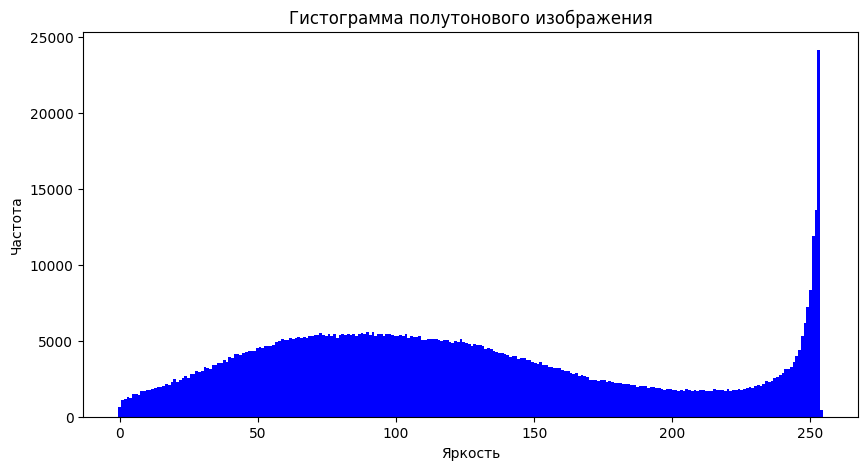

In [15]:
histogram, bins = np.histogram(gray_image, bins=256, range=(0, 255))

plt.figure(figsize=(10, 5))
plt.bar(bins[:-1], histogram, width=1, color='blue')
plt.title("Гистограмма полутонового изображения")
plt.xlabel("Яркость")
plt.ylabel("Частота")
plt.show()

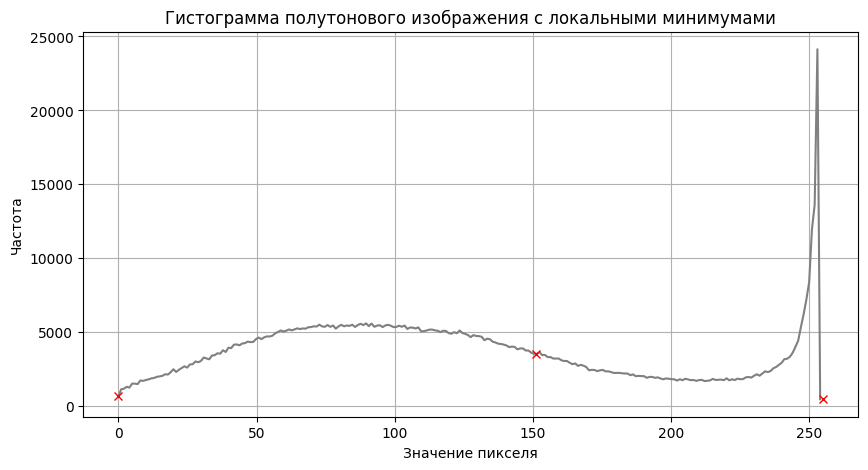

In [ ]:
# Простой гистограммный метод
def find_local_minimum_with_neighborhood(histogram, neighborhood_size):
    minima_indices = []
    for i in range(0, len(histogram), neighborhood_size):
        # Начальная точка
        start = i

        # Конечная точка с проверкой на выход за границы
        end = min(i + neighborhood_size, len(histogram))
        
        # Находим локальный минимум в текущей области
        local_min_index = start + np.argmin(histogram[start:end])
        minima_indices.append(local_min_index)
    
    return minima_indices

neighborhood_size = 50
minima_indices = find_local_minimum_with_neighborhood(histogram, neighborhood_size)

plt.figure(figsize=(10, 5))
plt.plot(bins[:-1], histogram, color='gray')
plt.plot(minima_indices, histogram[minima_indices], "rx")  
plt.title("Гистограмма полутонового изображения с локальными минимумами")
plt.xlabel("Значение пикселя")
plt.ylabel("Частота")
plt.grid(True)
plt.show()

# Простой гистограммный метод 
# def find_local_minimum_with_neighborhood(histogram, neighborhood_size):
#     minima_indices = []
#     i = neighborhood_size
    
#     while i < len(histogram):
#         # Границы области (окрестность <= точка => окрестность)
#         start = max(0, i - neighborhood_size)
#         end = min(i + neighborhood_size + 1, len(histogram))
        
#         # Локальный минимум в области
#         local_min_index = start + np.argmin(histogram[start:end])
        
#         # Проверка на локальный минимум
#         if (local_min_index == start or histogram[local_min_index] < histogram[local_min_index - 1]) and \
#            (local_min_index == end - 1 or histogram[local_min_index] < histogram[local_min_index + 1]):
#             minima_indices.append(local_min_index)
        
#         # Пропуск точки и ее окрестности
#         i = local_min_index + 2 * neighborhood_size + 1
    
#     return minima_indices

# neighborhood_size = 50
# minima_indices = find_local_minimum_with_neighborhood(histogram, neighborhood_size)

# plt.figure(figsize=(10, 5))
# plt.plot(bins[:-1], histogram, color='gray')
# plt.plot(minima_indices, histogram[minima_indices], "rx")  
# plt.title("Гистограмма полутонового изображения с локальными минимумами")
# plt.xlabel("Значение пикселя")
# plt.ylabel("Частота")
# plt.grid(True)
# plt.show()

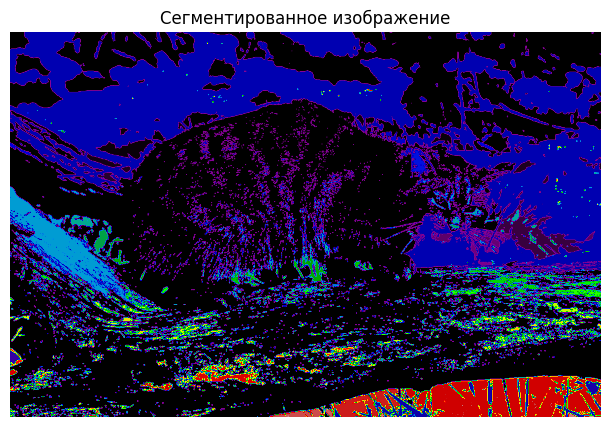

In [54]:
def apply_histogram_clustering(image, minima_indices):
    clustered_image = np.zeros_like(image)
    cluster_id = 1
    
    minima_indices = np.concatenate(([0], minima_indices, [256]))
    
    # Проход по парам соседних минимумов
    for i in range(len(minima_indices) - 1):
        lower_bound = minima_indices[i]
        upper_bound = minima_indices[i + 1]
        mask = (image >= lower_bound) & (image < upper_bound)
        clustered_image[mask] = cluster_id
        cluster_id += 1
    
    return clustered_image

def seed_growth_segmentation_with_init(image, clustered_image):

    height, width = image.shape
    
    segments_new = np.zeros((height, width), dtype=np.int32)
    current_segment = 1
    
    def grow_segment(x, y, cluster_id):
        stack = [(x, y)]
        
        while stack:
            cx, cy = stack.pop()
            
            # Проверка границ 
            if cx < 0 or cx >= height or cy < 0 or cy >= width:
                continue

            # Проверка, что пиксель уже помечен или не принадлежит текущему кластеру
            if segments_new[cx, cy] != 0 or clustered_image[cx, cy] != cluster_id:
                continue
            
            segments_new[cx, cy] = current_segment
            
            # Соседи
            stack.append((cx-1, cy))  
            stack.append((cx+1, cy))  
            stack.append((cx, cy-1))  
            stack.append((cx, cy+1))  
    
    # Проход по кластерам
    unique_clusters = np.unique(clustered_image)
    for cluster_id in unique_clusters:
        for i in range(height):
            for j in range(width):
                if segments_new[i, j] == 0 and clustered_image[i, j] == cluster_id:
                    grow_segment(i, j, cluster_id)
                    current_segment += 1
                    
    return segments_new

# Кластеризация
clustered_image = apply_histogram_clustering(gray_image, minima_indices)

# Применение алгоритма выращивания семян
segments_new = seed_growth_segmentation_with_init(gray_image, clustered_image)

plt.figure(figsize=(10, 5))
plt.title("Сегментированное изображение")
plt.axis('off')
plt.imshow(segments_new, cmap='nipy_spectral')
plt.show()


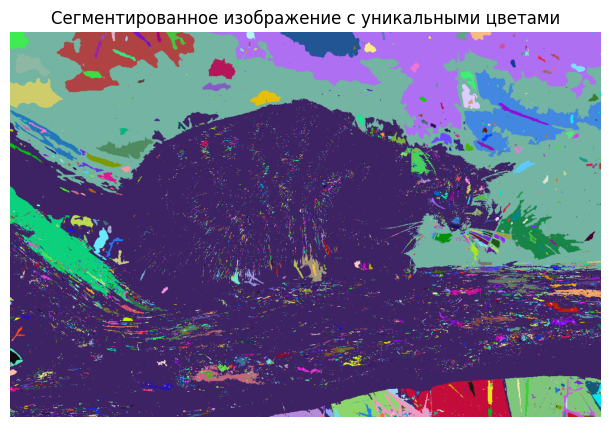

In [56]:
colored_image_new = color_segments(segments_new)

plt.figure(figsize=(10, 5))
plt.title("Сегментированное изображение с уникальными цветами")
plt.axis('off')
plt.imshow(colored_image_new)
plt.show()